In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.preprocessing import LabelBinarizer, OneHotEncoder, MultiLabelBinarizer, StandardScaler
from sklearn.metrics import mean_squared_error, max_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR, LinearSVR

from typing import Sequence

In [2]:
def reshape(df: pd.DataFrame, scale:bool =False, start=1960, stop=2016) -> pd.DataFrame:
    columns = df["Country Name"]
    index = range(start, stop+1)
    data = df[[f"{i}" for i in index]].to_numpy().T
    
    df = pd.DataFrame(data = data,
                        columns=columns,
                        index=index)
    if scale:
        df = ( df-df.mean() ) / df.std() 
    return df

In [3]:
def get_lags( X: pd.Series, lags):
        return pd.DataFrame(
            data={ f"-{i}": X.shift(i) for i in range(1,lags+1) }
        )

In [4]:
def to_lagged_mtvs_with_country(df: pd.DataFrame, lags=50):
    encoder = LabelBinarizer().fit(df.columns)
    new_df = pd.DataFrame(columns = ["y"] + list(df.columns))

    for col in df.columns:
        tseries = df[col]
        tseries.name = "y"
        encoded_country = pd.DataFrame(data=list(encoder.transform([col])) * len(tseries), 
                                       columns=encoder.classes_,
                                       index=tseries.index)
        tseries = pd.concat((tseries, 
                             get_lags(tseries, lags), 
                             encoded_country), 
                             axis=1)
        new_df = pd.concat((new_df, tseries))
    return new_df, encoder

In [5]:
class ForecastModel:
    def __init__(self, 
                 estimator = LinearRegression(), 
                 lags=5,
                 encode_country=True):
        self.estimator=estimator
        self.lags = lags
        self.encode_country = encode_country
    
    def fit(self, X, start=1960, stop=2016):
        self.raw = X
        
        mvts = self.__to_lagged_mvts(X.loc[start:stop])
        self.X = mvts.drop(columns="y")
        self.y = mvts["y"]
        
        self.min_year = self.X.index.min()
        self.estimator = self.estimator.fit(self.X, self.y)
        return self
    
    #similar function but skips by receiving parameters already runned
    #to speed up the search for the best parameters
    def faster_fit_country(self, X, lagged_data, encoder, start=1960, stop=2016):
        self.raw = X
        
        cols = [f"{-i}" for i in range(1, self.lags+1)] + list(encoder.classes_) + ["y"]
        lagged_data = lagged_data.loc[range(start+self.lags, stop+1), cols].dropna()
        
        self.X = lagged_data.drop(columns="y")
        self.y = lagged_data["y"]
        self.encoder=encoder
        
        self.min_year=self.X.index.min()
        self.estimator = self.estimator.fit(self.X, self.y)
        return self
    
    def faster_fit_no_country(self, X, lagged_data, start=1960, stop=2016):
        self.raw = X
        
        cols = [f"{-i}" for i in range(1, self.lags+1)] + ["y"]
        lagged_data = lagged_data.loc[range(start+self.lags, stop+1), cols].dropna()
        
        self.X = lagged_data.drop(columns="y")
        self.y = lagged_data["y"]
        
        self.min_year = self.X.index.min()
        self.estimator = self.estimator.fit(self.X, self.y)
        return self

    def predict(self, years: Sequence, country: str):
        X = []
        lags = range(1, self.lags+1)
        if self.encode_country:
            encoded_country = list(self.encoder.transform([country])[0])
            for year in years:
                assert(year>=self.min_year)
                X += [ 
                    [self.get_year(year - i, country) for i in lags] + encoded_country
                ]
        else:
            for year in years:
                assert(year>=self.min_year)
                X += [ 
                    [self.get_year(year - i, country) for i in lags]
                ]
            
        #model needed to have the labels that used in training
        X = pd.DataFrame(data = X,
                        columns = self.estimator.feature_names_in_) 
        return self.estimator.predict( X )
    
    def get_year(self, year: int, country : str) -> float:
        try: 
            data = self.raw.loc[year, country]
            if np.isnan(data):
                raise Exception()
            return data
        except:
            pred = self.predict([year], country)[0]
            self.raw.loc[year, country] = pred
            return pred

    def get_country(self, country:str):
        if self.encode_country:
            return self.y[self.X[country]==1]
        return self.raw[country]

    def __to_lagged_mvts(self, df: pd.DataFrame):
        if self.encode_country:
            self.encoder = LabelBinarizer().fit(df.columns)
            new_df = pd.DataFrame(columns = ["y"] + list(df.columns))
        
            for col in df.columns:
                tseries = df[col]
                tseries.name = "y"
                encoded_country = pd.DataFrame(data=list(self.encoder.transform([col])) * len(tseries), 
                                               columns=self.encoder.classes_,
                                               index=tseries.index)
                tseries = pd.concat((tseries, 
                                     self.__get_lags(tseries), 
                                     encoded_country), 
                                     axis=1).dropna()
                cols = [f"{-i}" for i in range(1, self.lags+1)] + list(self.encoder.classes_) + ["y"]
                new_df = pd.concat((new_df, tseries))[cols]
                
        else:
            new_df = pd.DataFrame(columns = ["y"])
            
            for col in df.columns:
                tseries = df[col]
                tseries.name = "y"

                tseries = pd.concat((tseries, 
                                     self.__get_lags(tseries)), 
                                     axis=1).dropna()
                cols = [f"{-i}" for i in range(1, self.lags+1)] + ["y"]
                new_df = pd.concat((new_df, tseries))[cols]
        return new_df

    def __get_lags(self, X: pd.Series):
        return pd.DataFrame(
            data={ f"{-i}": X.shift(i) for i in range(1,self.lags+1) }
        )

In [6]:
def plot_sub(ax, x, y, label="", xlabel="", ylabel="", title="", ms=5):
    ax.plot(x, y, ".", label=label, ms=ms)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if label!="":
        ax.legend()

def scat_sub(ax, x, y, label="", xlabel="", ylabel="", title=""):
    ax.scatter(x, y, label=label)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if label!="":
        ax.legend()
        
def scatter_ts(ax, x, y, title="", xlabel="", ylabel="", legend=""):
    ax.plot(x, y, "-o", alpha=0.5, label=legend)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if legend!="":
        ax.legend()

## Search Best Parameters

In [10]:
pop = pd.read_csv("data/country_population.csv")
life_expect = pd.read_csv("data/life_expectancy.csv")
fert_rate = pd.read_csv("data/fertility_rate.csv")

In [11]:
#change here input data
#pop, life_expect, fert_rate
data_ = pop
data = reshape(data_)

In [12]:
countries = list(data_["Country Name"].sample(n=10, random_state=66))

In [13]:
data_lagged, encoder = to_lagged_mtvs_with_country(data)

In [14]:
def search_best_no_country( X,
                            lagged_data,
                            countries = countries,
                            estimator = LinearRegression, 
                            lags: Sequence = [5], 
                            from_year = [1960],
                            metric = "pearson",
                            *args,
                            **kwargs):
    rmse = []
    pearson = []
    models = []
    parameters=[]
    
    test = X.loc[2016, countries]
    print(f"Number of iterations: {len(lags) * len(from_year)}")
    i=0
    for lag in lags:
        for start_year in from_year:
            i+=1
            if i%200==0: print("Iteration Nº:", i)
            
            time_diff = 2015 - start_year
            #if lag<time_diff:
            try:
                model = ForecastModel(estimator=estimator(**kwargs), 
                                       lags=lag,
                                      encode_country=False
                                     ).faster_fit_no_country( X, 
                                                               lagged_data,
                                                               start=start_year,
                                                               stop=2015)
                
                preds = [ model.predict([2016], country)[0] for country in countries ]
                rmse.append( mean_squared_error(test, preds, squared=False) )
                pearson.append( np.corrcoef(test, preds)[0,1] )
                models.append(model)
                parameters.append({"lags":lag, 
                                   "encode_country":False, 
                                   "train_range": (start_year, 2015)})
            except Exception as e:
                continue
    if metric == "pearson":
        idx = np.argmax(pearson)
    if metric == "rmse":
        idx = np.argmin(rmse)
    
    print("Processing Finished!")
    return (models[idx], 
            parameters[idx], 
            rmse[idx], 
            rmse[idx]/test.mean(),
            pearson[idx],
            {
             "params": parameters, 
             "pearson":pearson, 
             "rmse":rmse
            })

In [15]:
def search_best_encode_country( X,
                                lagged_data,
                                encoder,
                                countries = countries,
                                estimator = LinearRegression, 
                                lags: Sequence = [5], 
                                from_year = [1960],
                                metric = "pearson",
                                *args,
                                **kwargs
                              ):
    rmse = []
    pearson = []
    models = []
    parameters=[]
    test = X.loc[2016, countries]
    
    print(f"Number of iterations: {len(lags) * len(from_year)}")
    i=0
    for lag in lags:
        for start_year in from_year:
            i+=1
            if i%200==0: print("Iteration Nº:", i)
            
            try:
                model = ForecastModel(estimator=estimator(**kwargs), 
                                       lags=lag
                                     ).faster_fit_country( X, 
                                                           lagged_data,
                                                           encoder,
                                                           start=start_year,
                                                           stop=2015)

                
                preds = [ model.predict([2016], country)[0] for country in countries ]
                rmse.append( mean_squared_error(test, preds, squared=False) )
                pearson.append( np.corrcoef(test, preds)[0,1] )
                models.append(model)
                parameters.append({"lags":lag, 
                                   "encode_country":True, 
                                   "train_range": (start_year, 2015)})
            except Exception as e:
                continue
    if metric == "pearson":
        idx = np.argmax(pearson)
    if metric == "rmse":
        idx = np.argmin(rmse)
    
    print("Processing Finished!")
    return (models[idx], 
            parameters[idx], 
            rmse[idx], 
            rmse[idx]/test.mean(),
            pearson[idx], 
            {
                "params":parameters, 
                "pearson":pearson, 
                "rmse":rmse
            })

In [16]:
def save_results(fname, *args):
    pickle.dump(args, open(fname, "wb"))
    
def get_results(fname):
    return pickle.load(open(fname, "rb"))

In [17]:
def print_all(*args):
    print(f"""
    Best Parameters: {args[0]}
    Best RMSE: {args[1]}
    Best Pearson Corr.: {args[2]}
    """)

In [18]:
def print_best():
    print("Best by Pearson:")
    print_all(best_params, best_rmse, best_pcorr)
    
    print()
    idx = np.argmin(results["rmse"])
    
    print("Best by RMSE:")
    print_all(results["params"][idx], 
              results["rmse"][idx], 
              results["pearson"][idx])
    return idx

### No Country Encoding

In [ ]:
cols=[f"{-i}" for i in range(1,50+1)] + ["y"]

(best_model, 
 best_params, 
 best_rmse, 
 relative_rmse,
 best_pcorr,
results) = search_best_no_country(X=data,
                            lagged_data=data_lagged[cols],
                            estimator=LinearRegression,
                            lags=range(1,50),
                            from_year=range(1960, 2010+1),
                           )

In [20]:
idx=print_best()

Best by Pearson:

    Best Parameters: {'lags': 11, 'encode_country': False, 'train_range': (2003, 2015)}
    Best RMSE: 3234.0631832131257
    Best Pearson Corr.: 0.9999999989824311
    

Best by RMSE:

    Best Parameters: {'lags': 10, 'encode_country': False, 'train_range': (2004, 2015)}
    Best RMSE: 3126.7021388070043
    Best Pearson Corr.: 0.9999999988370707
    


In [ ]:
filename = "model.pickle"
save_results(filename, 
             best_model, 
             results["params"][idx], 
             results["rmse"][idx], 
             results["pearson"][idx])

### Country Encoding

In [ ]:
(best_model, 
 best_params, 
 best_rmse, 
 relative_rmse,
 best_pcorr,
results) = search_best_encode_country(X=data,
                                      lagged_data=data_lagged,
                                      encoder=encoder,
                                      estimator=LinearRegression,
                                      lags=range(1,50),
                                      from_year=range(1960, 2010+1),
                                    )

In [ ]:
idx=print_best()

In [ ]:
filename = "model_country.pickle"
save_results(filename, 
             best_model, 
             best_params, 
             best_rmse, 
             best_pcorr)

## Training Results: *Country Population*

| Statistic | Linear Regression | Support Vector Regressor | Decision Tree Regressor |
| :-: | :-: | :-: | :-: |
| Pearson Corr. | 0.9999999991 | 0.9998747104 | 0.9999998768 |
| RMSE | 1847.51 | 42847224.96 | 80602.88 |

| Parameter | Linear Regression | Support Vector Regressor | Decision Tree Regressor |
| :-: | :-: | :-: | :-: |
| lags | 4 | 46 | 8 |
| start | 2010 | 1969 | 1962 |
| encode_country | True | False | True |

## Training Results: *Fertility Rate*

| Statistic | Linear Regression | Support Vector Regressor | Decision Tree Regressor |
| :-: | :-: | :-: | :-: |
| Pearson Corr. | 0.9999872 | 0.9999889 | 0.9999892 |
| RMSE | 0.0081 | 0.0076 | 0.0100 |

| Parameter | Linear Regression | Support Vector Regressor | Decision Tree Regressor |
| :-: | :-: | :-: | :-: |
| lags | 11 | 6 | 2 |
| start | 2002 | 2000 | 2007 |
| encode_country | False | False | True |

## Training Results: *Life Expectancy*

| Statistic | Linear Regression | Support Vector Regressor | Decision Tree Regressor |
| :-: | :-: | :-: | :-: |
| Pearson Corr. | 0.9999957 | 0.9998677 | 0.9999354 |
| RMSE | 0.034 | 0.120 | 0.079 |

| Parameter | Linear Regression | Support Vector Regressor | Decision Tree Regressor |
| :-: | :-: | :-: | :-: |
| lags | 12 | 11 | 1 |
| start | 1960 | 1996 | 1963 |
| encode_country | False | False | True |

## Testing on 2017 and 2018

In [21]:
test_pop = pd.read_csv("data/country_population_test.csv", index_col=0)
test_fert_rate = pd.read_csv("data/fertility_rate_test.csv", index_col=0)
test_life_expect = pd.read_csv("data/life_expectancy_test.csv", index_col=0)

In [22]:
#change here input data
#test_pop, test_life_expect, test_fert_rate
test = test_pop

#pop, life_expect, fert_rate
data = pop
data = reshape(data)

In [23]:
#model selection
model = ForecastModel(estimator=LinearRegression(), encode_country=True, lags=4).fit(data, start=2010)

In [25]:
y_test=test.loc[2017:2018]

In [24]:
preds = np.array([ model.predict([2017, 2018], country) for country in countries]).T

In [26]:
k=0
print(f"{2017 + k} rmse = {mean_squared_error( y_test.loc[2017+k], preds[k], squared=False)}")

2017 rmse = 143320.40664246632


In [27]:
print(f"Total rmse = {mean_squared_error( y_test, preds, squared=False)}")

Total rmse = 101047.21289282758


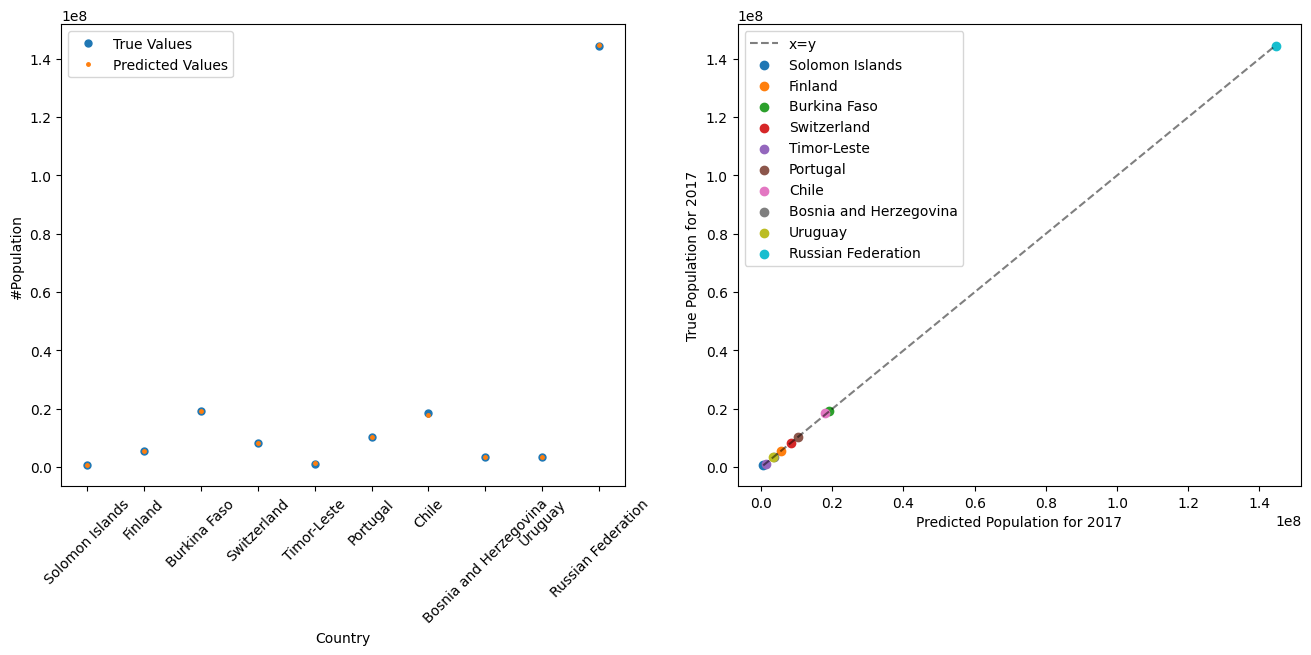

In [28]:
k=0
x_ = range(len(countries))

f, ax = plt.subplots(1,2, figsize=(16,6))
plot_sub(ax[0], x_, y_test.loc[2017+k], label="True Values", ms=10)
plot_sub(ax[0], x_, preds[k], label="Predicted Values", xlabel="Country", ylabel="#Population")
ax[0].set_xticks(x_, countries, rotation=45)

xy=np.linspace(preds[k].min(), preds[k].max())
ax[1].plot(xy,xy, "--k", alpha=0.5, label="x=y")

for i, country in enumerate(countries):
    scat_sub(ax[1], [preds[k,i]], [y_test.loc[2017+k, country]], 
             xlabel=f"Predicted Population for {2017+k}", 
             ylabel=f"True Population for {2017+k}", 
             label=country)

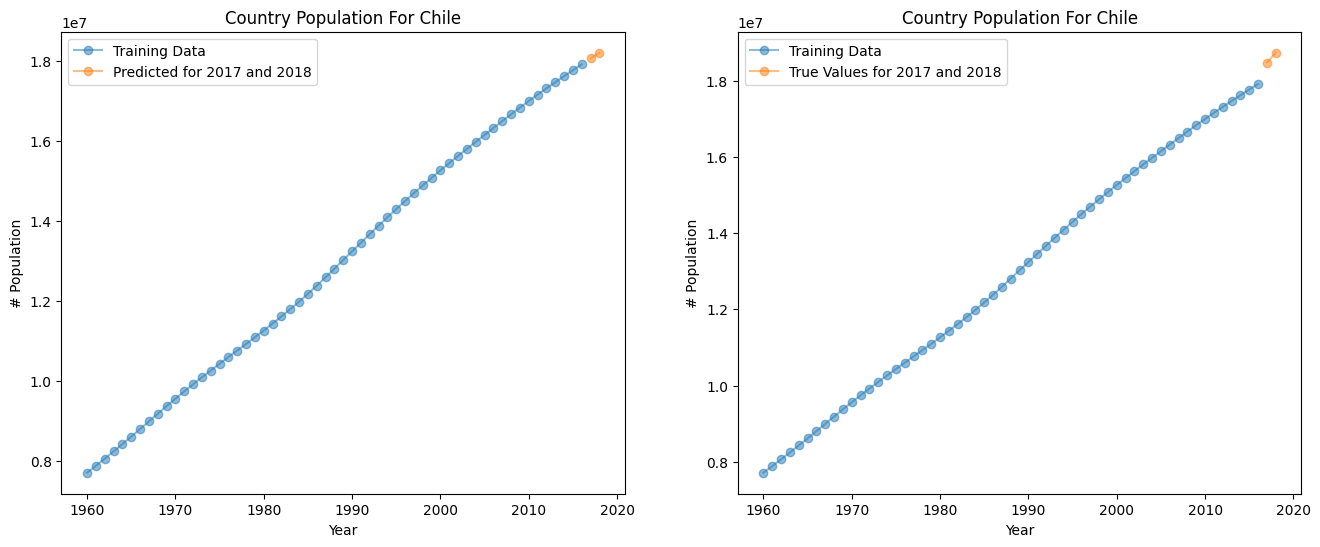

In [33]:
#country label index
i=6
f, ax = plt.subplots(1,2, figsize=(16,6))

scatter_ts(ax[0], data.loc[:2016].index, data.loc[:2016, countries[i] ], legend="Training Data")

scatter_ts(ax[0], [2017, 2018], preds[:, i], 
           title=f"Country Population For {countries[i]}", xlabel="Year",
           ylabel="# Population", legend="Predicted for 2017 and 2018")

scatter_ts(ax[1], data.loc[:2016].index, data.loc[:2016, countries[i] ], legend="Training Data")

scatter_ts(ax[1], [2017, 2018], y_test[ countries[i] ], 
           title=f"Country Population For {countries[i]}", xlabel="Year",
           ylabel="# Population", legend="True Values for 2017 and 2018")